In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

In [28]:
df=pd.read_csv(r'E:/python/kaggle/archive/character.csv')
datasets=df.groupby('data set')
train_df=datasets.get_group('train')
test_df=datasets.get_group('test')
valid_df=datasets.get_group('valid')
# change the filepaths column to be the full path to an image
train_df['filepaths']=train_df['filepaths'].apply(lambda x: os.path.join(r'E:/python/kaggle/archive/', x))
test_df['filepaths']=test_df['filepaths'].apply(lambda x: os.path.join(r'E:/python/kaggle/archive/', x))
valid_df['filepaths']=valid_df['filepaths'].apply(lambda x: os.path.join(r'E:/python/kaggle/archive/', x))

# print out an imagepath to check
print(train_df['filepaths'].iloc[0])
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
# check the class sample balance of the train_df dataframe
print(train_df['labels'].value_counts())

E:/python/kaggle/archive/train/savory/0001.jpg
train_df length:  11220   test_df length:  600   valid_df length:  600
savory      5610
unsavory    5610
Name: labels, dtype: int64


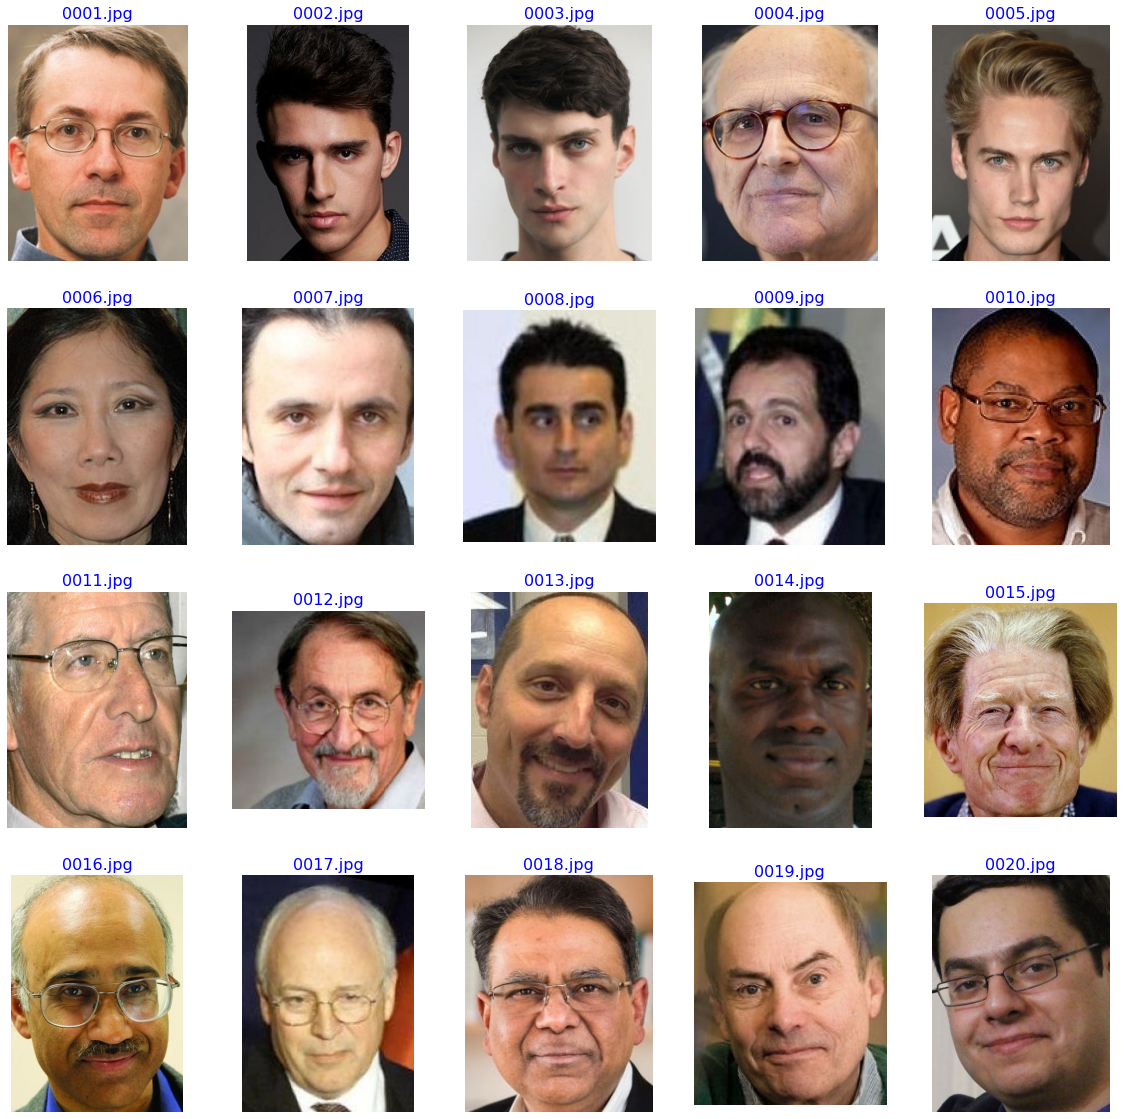

Average height=  377   average width=  294  average aspect ratio h/w=  1.282312925170068  image shape:  (300, 233, 3)


In [29]:
# train_df is balanced, Lets look at about 200 training images and get the average height, width and aspect ratio
#to use to select an image size for the model
savory_train_dir=r'E:/python/kaggle/archive/train/savory' # select one of the class directories in train set
flist=sorted(os.listdir(savory_train_dir)) # get a list of the files

ht, wt, file_count = 0,0,200
plt.figure(figsize=(20,20))
for i, f in enumerate(flist): # iterate through the files
    if i >=file_count:
        break  # only lok at first file_count number of files to save time
    else: #As long as we are here might as well show 20 training images
        imgpath=os.path.join(savory_train_dir,f)
        img=plt.imread(imgpath)
        h,w,c=np.shape(img) # use numpy shape returns height, width
        ht += h
        wt += w
        if i < 20:
            plt.subplot(4,5,i+1)
            plt.axis('off')
            plt.title(f, color='blue', fontsize=16)
            plt.imshow(img)
plt.show()
ave_h=int(ht/file_count)
ave_w=int(wt/file_count)
aspect_ratio=ave_h/ave_w
# select an image size for the model 300 pixel height should be adequate to capture image features
img_size=(300, int(300/aspect_ratio))
img_shape=(img_size[0], img_size[1], 3)
print('Average height= ', ave_h, '  average width= ', ave_w, ' average aspect ratio h/w= ', aspect_ratio, ' image shape: ', img_shape)

In [30]:
# create train, test and valid generators
batch_size=30 # We will use and EfficientetB3 model, with image size of (300,233) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True)
t_and_v_gen=ImageDataGenerator()

train_gen=trgen.flow_from_dataframe(train_df, 
                                    x_col='filepaths', 
                                    y_col='labels', 
                                    target_size=img_size,
                                   class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)

valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, 
                                          x_col='filepaths',
                                          y_col='labels', 
                                          target_size=img_size,
                                           class_mode='categorical', 
                                          color_mode='rgb', 
                                          shuffle=False, 
                                          batch_size=batch_size)

# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.

test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)

test_gen=t_and_v_gen.flow_from_dataframe(test_df, 
                                         x_col='filepaths', 
                                         y_col='labels', 
                                         target_size=img_size,
                                   class_mode='categorical', 
                                         color_mode='rgb', 
                                         shuffle=False, 
                                         batch_size=test_batch_size)
# from the generator we can get information we will need later

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)

labels=test_gen.labels
"""print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^12s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^12s}{str(index):^12s}')"""

Found 11220 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


"print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)\nprint ('{0:^12s}{1:^12s}'.format('class name', 'class index'))\nfor klass, index in zip(classes, class_indices):\n    print(f'{klass:^12s}{str(index):^12s}')"